In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import deepchem as dc
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from IPython.display import SVG

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

%matplotlib inline

### Load data set 


In [12]:
dataset_file = "../deepchem/datasets/gdb1k.sdf"
featurizer = dc.feat.CoulombMatrixEig(23, remove_hydrogens=False)

loader = dc.data.SDFLoader(
      tasks=["atomization_energy"], smiles_field="smiles",
      featurizer=featurizer,
      mol_field="mol")
dataset = loader.featurize(dataset_file)


Loading raw samples now.
shard_size: 8192
Reading structures from ../deepchem/datasets/gdb1k.sdf.
Currently featurizing feature_type: CoulombMatrixEig
Featurizing sample 0
TIMING: featurizing shard 0 took 0.691 s
TIMING: dataset construction took 0.924 s
Loading dataset from disk.


Hansen et al (2013) state that normalisation scaling of inputs is detrimental to model performance as the input dimensions are related. 
In this notebook, we will compare the performance of scaled and non-scaled inputs. 



In [13]:
# Split dataset
random_splitter = dc.splits.RandomSplitter()
#stratified_splitter = dc.splits.RandomStratifiedSplitter(
train_dataset, valid_dataset, test_dataset = random_splitter.train_valid_test_split(dataset)

train_dataset.X

TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.


array([[ 76.92413224,  43.71453008,  24.43381371, ...,   0.        ,
          0.        ,   0.        ],
       [101.3829054 ,  50.17331876,  41.7690626 , ...,   0.        ,
          0.        ,   0.        ],
       [ 90.71110392,  39.01415505,  38.47358737, ...,   0.13525954,
          0.        ,   0.        ],
       ...,
       [ 91.97377619,  47.78413284,  40.41271279, ...,   0.        ,
          0.        ,   0.        ],
       [111.7206627 ,  63.42463856,  42.9667269 , ...,   0.        ,
          0.        ,   0.        ],
       [ 97.32119223,  48.19390111,  29.89943902, ...,   0.        ,
          0.        ,   0.        ]])

In [14]:
# Apply normalisation transformer
transformers = [
    dc.trans.NormalizationTransformer(transform_X=True, dataset=dataset),
    dc.trans.NormalizationTransformer(transform_y=True, dataset=dataset)]

normalised = {}

for name,dataset in zip(['train', 'valid', 'test'],[train_dataset, valid_dataset, test_dataset]):
    for transformer in transformers:
        normalised[name] = transformer.transform(dataset)

normalised['train'].X

TIMING: dataset construction took 0.023 s
Loading dataset from disk.
TIMING: dataset construction took 0.020 s
Loading dataset from disk.
TIMING: dataset construction took 0.013 s
Loading dataset from disk.
TIMING: dataset construction took 0.018 s
Loading dataset from disk.
TIMING: dataset construction took 0.012 s
Loading dataset from disk.
TIMING: dataset construction took 0.009 s
Loading dataset from disk.


array([[ 76.92413224,  43.71453008,  24.43381371, ...,   0.        ,
          0.        ,   0.        ],
       [101.3829054 ,  50.17331876,  41.7690626 , ...,   0.        ,
          0.        ,   0.        ],
       [ 90.71110392,  39.01415505,  38.47358737, ...,   0.13525954,
          0.        ,   0.        ],
       ...,
       [ 91.97377619,  47.78413284,  40.41271279, ...,   0.        ,
          0.        ,   0.        ],
       [111.7206627 ,  63.42463856,  42.9667269 , ...,   0.        ,
          0.        ,   0.        ],
       [ 97.32119223,  48.19390111,  29.89943902, ...,   0.        ,
          0.        ,   0.        ]])

train ((792, 23), (792, 1), (792, 1), (792,))
valid ((99, 23), (99, 1), (99, 1), (99,))
test ((100, 23), (100, 1), (100, 1), (100,))


RDKit ERROR: [09:25:37] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [09:25:37] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [09:25:37] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [09:25:37] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [09:25:37] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [09:25:37] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [09:25:37] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [09:25:37] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [09:25:37] Explicit valence for atom # 4 N, 4, is greater than permitted


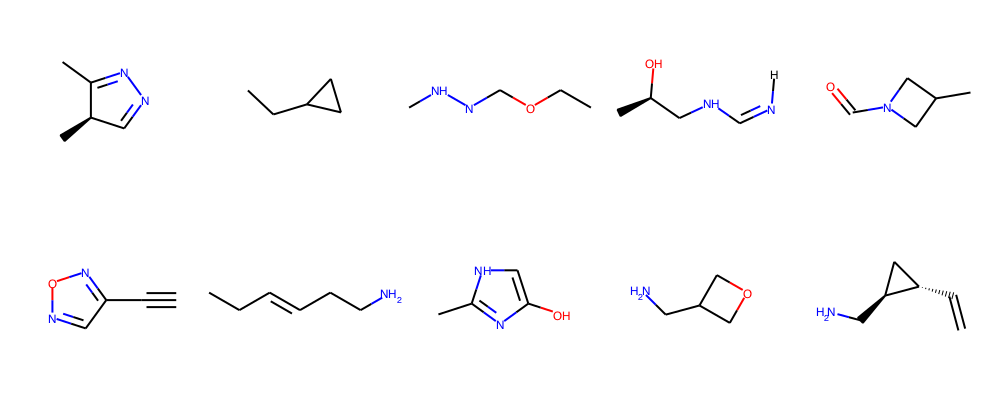

In [16]:
## Dataset analysis

def moltosvg(mol,molSize=(280,80),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

for data, name in zip([train_dataset, valid_dataset, test_dataset],['train', 'valid', 'test']):
    print(name, data.get_shape())
   # print(name, data.get_statistics())
    mol_list = [Chem.MolFromSmiles(id_) for id_ in data.ids]
    #SVG(moltosvg(mol_list[0]))

Chem.Draw.MolsToGridImage(mol_list[:10], molsPerRow=5)#legends=[mol.GetProp('_Name') for mol in mol_list[:10]])

# mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
# Chem.Draw.MolsToGridImage(mol_list,legends=[mol.GetProp('_Name') for mol in mol_list])

## Keras Neural Networks

In [17]:
## Functions

def plot_history(history, title):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig, ax = plt.subplots(1,2, figsize=(12,6))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Abs Error')
    ax[0].plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    ax[0].plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    ax[0].set_title(title)
    #plt.ylim([0,5])
    ax[0].legend()
    
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Square Error')
    ax[1].plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    ax[1].plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    #plt.ylim([0,20])
    ax[1].set_title(title)
    ax[1].legend()
    plt.show()

In [42]:
## Keras implementation 
from tensorflow import keras

# Initializer
# Initialise weights according to Hansen et al (2013)
initializer = keras.initializers.RandomNormal(mean=0, stddev=(1/np.sqrt(100)))

# Network

model = tf.keras.Sequential([
keras.layers.Dense(792, activation='sigmoid', input_shape=(23,), kernel_initializer=initializer),
keras.layers.Dense(400, activation='sigmoid'),
keras.layers.Dense(100, activation='sigmoid'),
#keras.layers.Dense(100, activation='sigmoid'),
keras.layers.Dense(1)])

# Configure a model for mean-squared error regression.
model.compile(optimizer='sgd',
              loss='mse',       # mean squared error
              metrics=['mae', 'mse'])  # mean absolute error

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

# Save model weights checkpoint
model_checkpoint = keras.callbacks.ModelCheckpoint('sgd_model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')


X_train = train_dataset.X
y_train = train_dataset.y

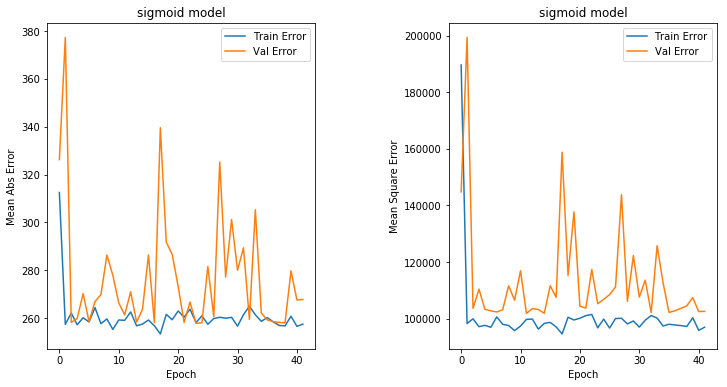

In [43]:
history = model.fit(X_train, y_train, validation_split = 0.1, epochs=500, 
                    callbacks=[early_stop, model_checkpoint], batch_size=25, verbose=0)

plot_history(history, "sigmoid model")

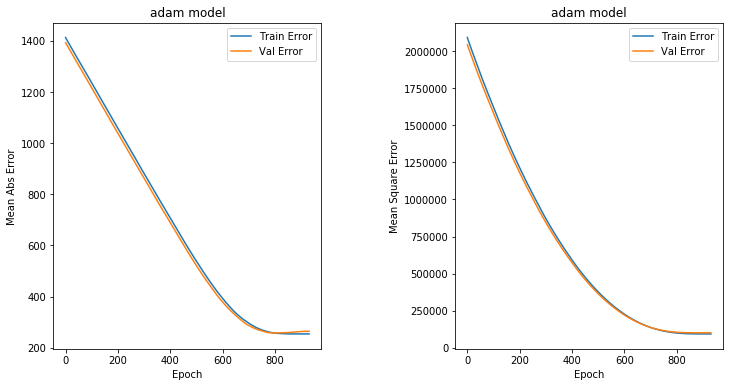

In [45]:
# Configure a model for mean-squared error regression.
model_adam = tf.keras.Sequential([
keras.layers.Dense(792, activation='sigmoid', input_shape=(23,), kernel_initializer=initializer),
keras.layers.Dense(400, activation='sigmoid', input_shape=(23,)),
keras.layers.Dense(100, activation='sigmoid'),
#keras.layers.Dense(100, activation='sigmoid'),
keras.layers.Dense(1)])

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint('adam_model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')

model_adam.compile(optimizer='adam',
              loss='mse',       # mean squared error
              metrics=['mae', 'mse'])  # mean absolute error

history_adam = model_adam.fit(X_train, y_train, validation_split = 0.1, epochs=2000, 
                    callbacks=[early_stop, model_checkpoint], batch_size=25, verbose=0)

plot_history(history_adam, "adam model")

## DeepChem Multitask Regressor

In [ ]:
from deepchem.molnet import load_qm7_from_mat
from deepchem.models.tensorgraph.optimizers import ExponentialDecay

print(tf.__version__)

qm7_tasks, datasets, transformers = load_qm7_from_mat(
    split='stratified', move_mean=True, reload=False)


qm_train, qm_valid, qm_test = datasets

fit_transformers = [dc.trans.CoulombFitTransformer(qm_train)]

rate = 0.001
dc_model = dc.models.MultitaskFitTransformRegressor(
    n_tasks=1,
    n_features=[23, 23],
    learning_rate=rate,
    momentum=.8,
    batch_size=25,
    weight_init_stddevs=[1 / np.sqrt(400), 1 / np.sqrt(100), 1 / np.sqrt(100)],
    bias_init_consts=[0., 0., 0.],
    layer_sizes=[400, 100, 100],
    dropouts=[0.01, 0.01, 0.01],
    fit_transformers=fit_transformers,
    n_evals=10,
    seed=123)




In [ ]:
# Fit trained model
dc_model.fit(qm_train, nb_epoch=50)

train_scores = dc_model.evaluate(qm_train, metric, transformers)
valid_scores = dc_model.evaluate(qm_valid, metric, transformers)

In [ ]:
def krr_model_builder(model_params, model_dir):
    sklearn_model = KernelRidge(**model_params)
    return dc.models.SklearnModel(sklearn_model, model_dir)

params_dict = {
    "kernel": ["laplacian", "linear"],
    "alpha": [0.0001, 0.001, 0.01, 0.01],
    "gamma": [0.0001, 0.001, 0.01, 0.1]
}

metric = dc.metrics.Metric(dc.metrics.mean_absolute_error)

optimizer = dc.hyper.HyperparamOpt(krr_model_builder)
best_krr, best_krr_hyperparams, all_krr_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)
